# Data Loading

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



# using the SQLite Table to read data.
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

# Data Cleaning

In [2]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)

#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

# Data Pre-processing

In [3]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [4]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

# Time Based Sorting

In [5]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# Data Sampling

In [6]:
# taking 10000 reviews 
final = final.iloc[0:10000]
sample_data = final['CleanedText']

# Elbow Method for finding EPS

In [7]:
#Function to get optimal EPS
from sklearn.neighbors import NearestNeighbors
def getEPS(neighbors,vector):
    nbrs = NearestNeighbors(n_neighbors=neighbors).fit(vector)
    distances, indices = nbrs.kneighbors(vector)
    distanceDec = sorted(distances[:,neighbors-1], reverse=True)
    plt.plot(indices[:,0],distanceDec,)

# DBScan Clustering

In [18]:
#function to applying DBscan
from sklearn.cluster import DBSCAN
def applyDBScanclustering(vector,e):
    dbscan= DBSCAN(eps=e)
    dbscan = dbscan.fit(vector)
    return dbscan

# Retrieving data from clusters

In [9]:
#function to retrieve data from clusters
from wordcloud import WordCloud, STOPWORDS 
def retrieveDataFromCluster(cluster,feature_names):
    stopwords = set(STOPWORDS) 
    cluster_labels = cluster.labels_
    clusters_data = {}
    for document_id,label in enumerate(cluster_labels):
        if label not in clusters_data:
            clusters_data[label] = []
        clusters_data[label].append(document_id)

    for i in clusters_data:
        print("\n Cluster %d:" % i),
        print("===================")
        text =' '
        words = clusters_data.get(i)
        for index in words[0:100]:
            text = text + feature_names[index]+' '
        wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, 
                min_font_size = 10).generate(text) 
        # plot the WordCloud image                        
        plt.figure(figsize = (8, 8), facecolor = None) 
        plt.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        plt.show() 

# Featurization using AvgW2Vec

In [10]:
# Train your own Word2Vec model using sample_data
import warnings
import gensim
warnings.filterwarnings("ignore")

i=0
list_of_sent_sample_data=[]
for sent in sample_data:
    sent = sent.decode('utf-8')
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_sample_data.append(filtered_sentence)

In [11]:
w2v_model=gensim.models.Word2Vec(list_of_sent_sample_data,min_count=1,size=50, workers=4) 

In [12]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_sample_data = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_sample_data: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_sample_data.append(sent_vec)
avgw2v_vector = sent_vectors_sample_data

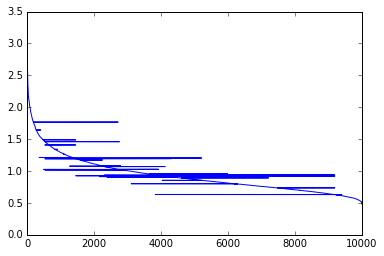

In [32]:
getEPS(100,avgw2v_vector)

# DBSScan with Optimal EPS - AVGW2V


 Cluster 0:


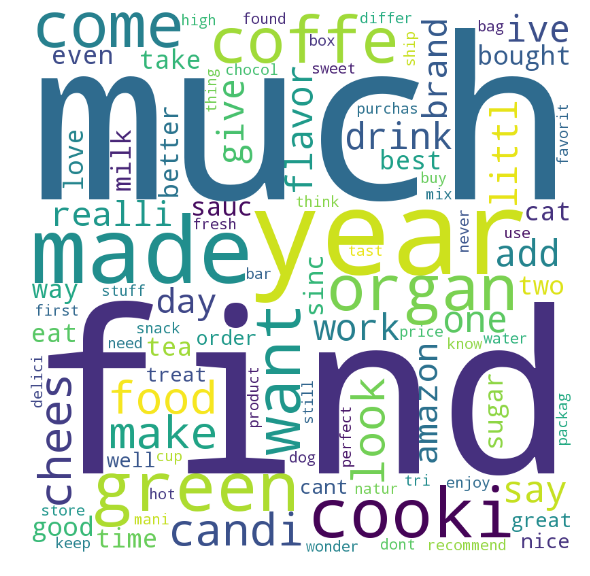


 Cluster -1:


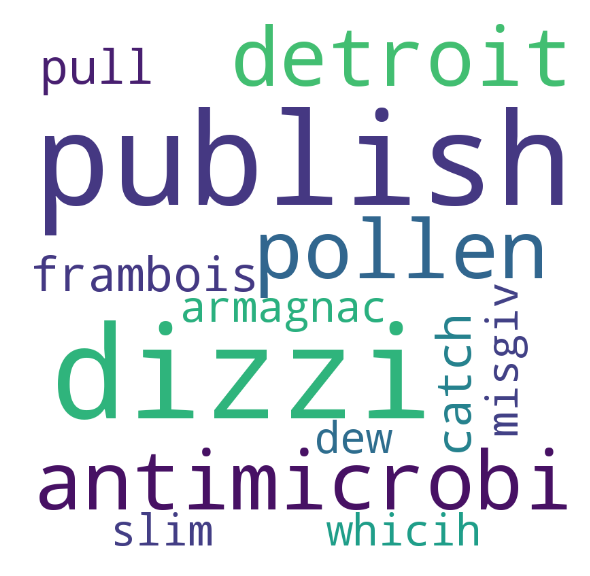

In [25]:
#apply model on AVGW2V vectorizer with optimal eps and retrieving data from clusters
feature_names =  w2v_model.wv.index2word
avgW2VCluster = applyDBScanclustering(avgw2v_vector,1.5)
retrieveDataFromCluster(avgW2VCluster,feature_names)

# Featurization using TFIDFW2Vec

In [14]:
tf_idf_sample_data_vect = TfidfVectorizer()
tf_idf_sample_data_vect.fit(sample_data)
final_tf_idf_sample_data_vect = tf_idf_sample_data_vect.transform(sample_data)

In [15]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_sample_data_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_sample_data_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_sample_data: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try: 
            
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf_sample_data_vect[row, tfidf_feat.index(word)]
            sent_vec +=(vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_sample_data_vectors.append(sent_vec)
    row += 1
tfidfw2v_vector = tfidf_sent_sample_data_vectors

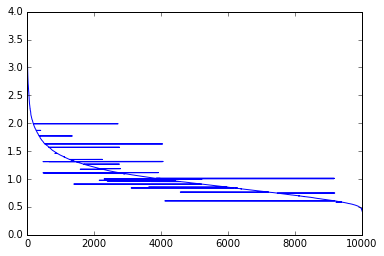

In [33]:
getEPS(100,tfidfw2v_vector)

# DBSScan with Optimal EPS - TFIDFW2V


 Cluster 0:


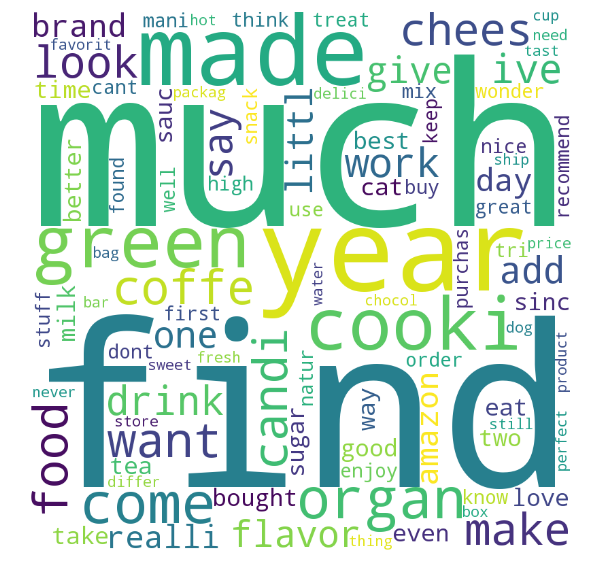


 Cluster -1:


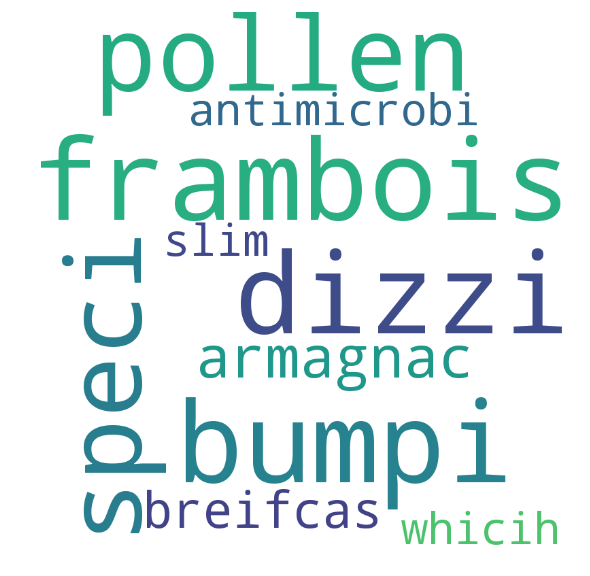

In [35]:
#apply model on tfidfw2v vectorizer with optimal eps and retrieving data from clusters
feature_names =  w2v_model.wv.index2word
tfidfW2VCluster = applyDBScanclustering(tfidfw2v_vector,1.6)
retrieveDataFromCluster(tfidfW2VCluster,feature_names)

# eps=1


 Cluster 0:


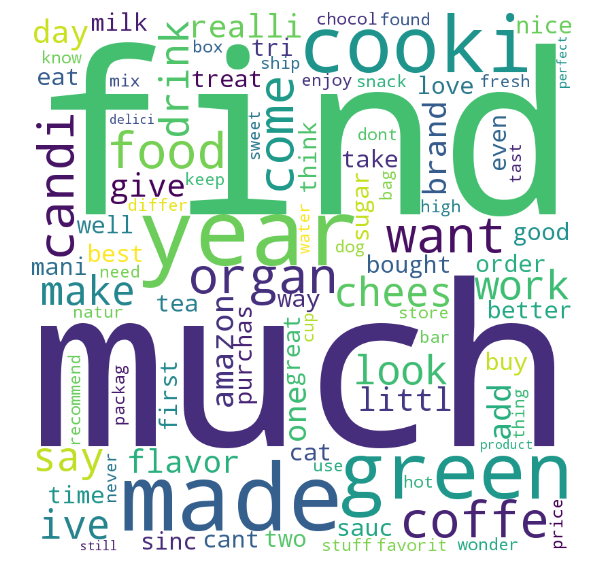


 Cluster -1:


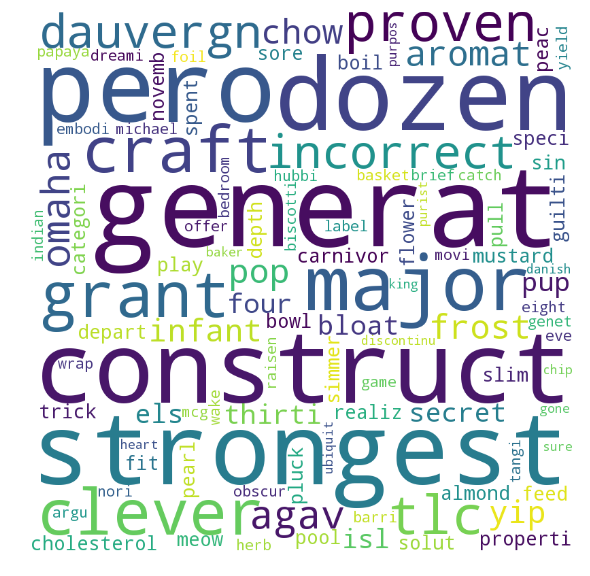

In [36]:
#apply model on tfidfw2v vectorizer with optimal eps and retrieving data from clusters
feature_names =  w2v_model.wv.index2word
tfidfW2VCluster = applyDBScanclustering(tfidfw2v_vector,1)
retrieveDataFromCluster(tfidfW2VCluster,feature_names)

# eps=2


 Cluster 0:


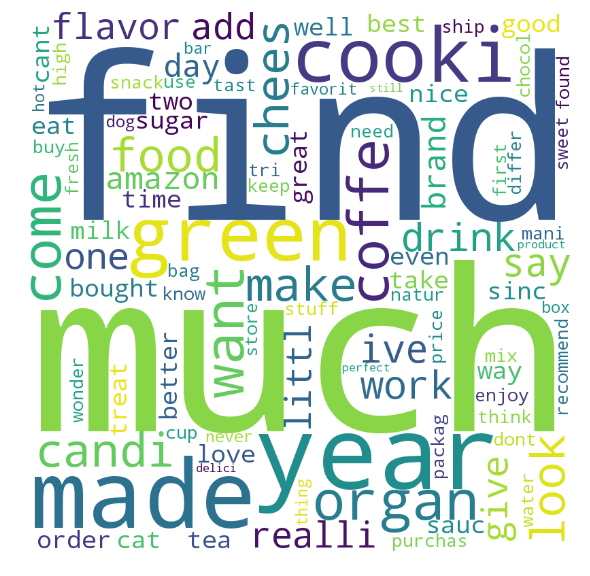

In [37]:
#apply model on tfidfw2v vectorizer with eps=2 and retrieving data from clusters
feature_names =  w2v_model.wv.index2word
tfidfW2VCluster = applyDBScanclustering(tfidfw2v_vector,2)
retrieveDataFromCluster(tfidfW2VCluster,feature_names)

# Conclusion

In [ ]:
from prettytable import PrettyTable
t = PrettyTable()
t.field_names = ['Featurization', 'Hyperparameter(eps)']
t.add_row(["AVGW2V","1.5"])
t.add_row(["TFIDFW2V","1.6"])
print(t)